In [1]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

import os
import requests
from typing import List, Union, Optional
import pandas as pd 
import matplotlib.pyplot as plt


# API Requests to the NRFA site
from src.data.nrfa_api import NrfaDataCollector
from src.constants import DATA_PATH

In [2]:
api = NrfaDataCollector()

# Check if discharge in Camels GB corresponds to flow in NRFA data

By reading through the Camels GB generation [code](https://github.com/naddor/camels) it occured to me that there is no calculation of the discharge data. Instead, they point to the NRFA as a source for their discharge data. This seems to imply that their __discharge__ variable does not correspond to __runoff__ but to __flow__ at the catchmet river gauge instead. 

To quickly test this hypothesis, I look at a few randomly selected stations in the Camels GB dataset and 
compare the __discharge__ variable to the __flow__ I get from the NRFA Data API for the same station.

In [3]:
# A few random stations in Camels GB to check hypothesis whether the
# discharge in Camels GB corresponds directly to the flow in NRFA data
stations = [40018, 9005, 12007]

# CAMELS DATA
camels_paths = [
    os.path.join(
        DATA_PATH,
        "Camels_GB",
        "data",
        "timeseries",
        f"CAMELS_GB_hydromet_timeseries_{station}_19701001-20150930.csv",
    )
    for station in stations
]
camels_timeseries = [
    pd.read_csv(file, index_col="date", parse_dates=True) for file in camels_paths
]

# NRFA DATA
# gdf = (mean) gauged daily flows [m3/s]
gdf_data = [api.get_timeseries(station, "gdf") for station in stations]
station_names = [data["station"]["name"] for data in gdf_data]
gdf_timeseries = [api._nrfa_timeseries_to_pandas(data) for data in gdf_data]

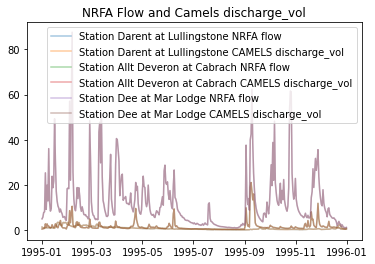

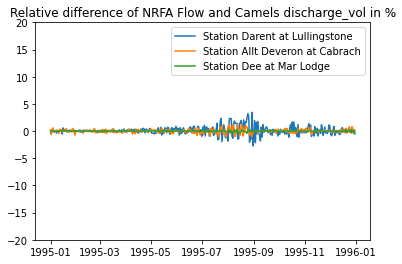

In [4]:
def plot_relative_diff(daterange):

    for i in range(len(stations)):
        ts1 = gdf_timeseries[i]
        ts2 = camels_timeseries[i].discharge_vol

        plt.plot(ts1[daterange], label=f"Station {station_names[i]} NRFA flow", alpha=0.4)
        plt.plot(ts2[daterange], label=f"Station {station_names[i]} CAMELS discharge_vol", alpha=0.4)

    plt.legend()
    plt.title("NRFA Flow and Camels discharge_vol")
    plt.show()
    
    for i in range(len(stations)):
        ts1 = gdf_timeseries[i]
        ts2 = camels_timeseries[i].discharge_vol

        rel_diff = (ts1[daterange] - ts2[daterange]) / abs(ts1[daterange])

        plt.plot(rel_diff * 100, label=f"Station {station_names[i]}")

    plt.ylim(-20, 20)
    plt.legend()
    plt.title("Relative difference of NRFA Flow and Camels discharge_vol in %")
    plt.show()
    
    
plot_relative_diff("1995")

By plotting the relative difference for several years, we see that the CAMELS discharge_vol and the NRFA Flow values are essentially the same (the small devaitions occur due to rounding in CAMELS GB, as seen by more closely investigating the data.

## Conclusion: 

Our run-off to river-stage workstream is not needed as the output variable of our LSTM will be "FLOW" and we already have a "FLOW to RIVER_STAGE" mapping.

# Collect shipston Flow data

In [174]:
shipston = 54106 # NRFA id of shipston

shipston_gdf_response = api.get_timeseries(shipston, "gdf")
shipston_flow_nrfa = api._nrfa_timeseries_to_pandas(shipston_gdf_response)

In [175]:
# Let's quickly check for extreme values and missing values
print(f"Missing values: {shipston_flow_nrfa.isna().sum()}")

print("Basic statistics:")
print(shipston_flow_nrfa.describe())

Missing values: 0
Basic statistics:
count    5386.000000
mean        1.560127
std         2.900246
min         0.186000
25%         0.430250
50%         0.762500
75%         1.527000
max        93.700000
Name: Gauged Daily Flow [m3/s], dtype: float64


We see that the data does not include any negative or missing values, let's briefly plot it to get an idea of what the time series looks like.

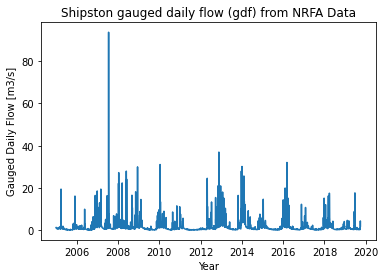

In [176]:
plt.plot(shipston_flow_nrfa)
plt.ylabel(shipston_flow_nrfa.name)
plt.title("Shipston gauged daily flow (gdf) from NRFA Data")
plt.xlabel("Year");

Not that in particular we have flow data from __1st January 2005__ to __30th September 2019__ from the NRFA API.

Looking at the data from Matt's notebook, we see that the 60min Wiski data that the EA gave us actually covers more of the available date range and maps nicely (at least visually) to what we observe here (the higher value of 175 m3/s max flow is because the NRFA Data API gives us the mean daily flow while the WISKI data has 24 values per day (60 min update frequency)). On the day of flooding in 2007, the max flow values was about 2-3 times higher than the daily mean flow. 

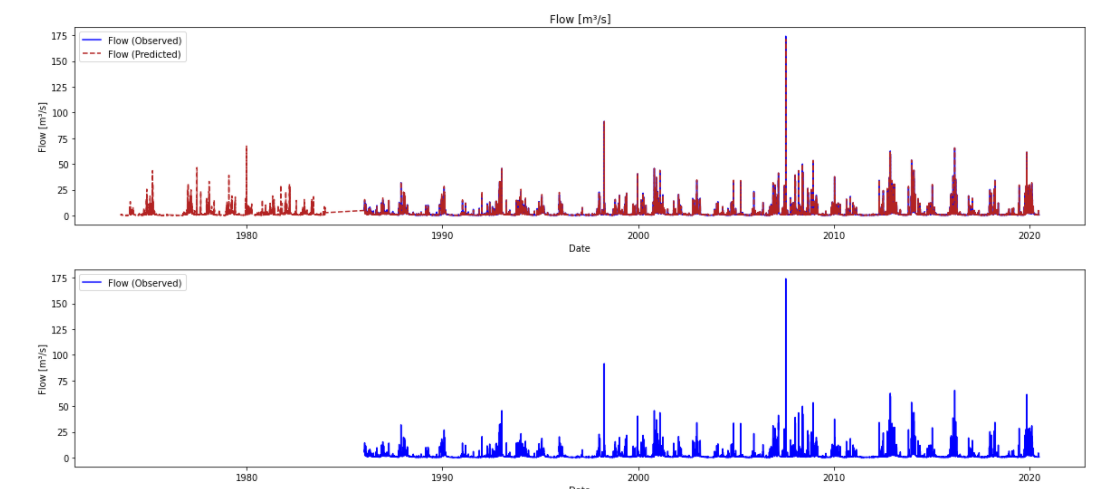

## Conclusion:
We should use the EA Wiski data (and Matt's extrapolation from stage to flow) instaed of the NRFA API data for flow in Shipston. This will give us data from ~1970 to 2020.

The __flow__ variable should be mapped to __discharge_vol__ in CAMELS GB and __discharge_spec__ is calculated as 

$$ \text{discharge_spec} =  \dfrac{\text{discharge_vol}}{\text{catchment_area}}$$.

For shipston the catchment area is

In [35]:
shipston_catchment_area = api.get_static_data(shipston, ["catchment-area"])["data"][0][
    "catchment-area"
]
print(
    f"Shipston catchment area: {shipston_catchment_area} km^2, i.e. {shipston_catchment_area*1e6} m^2"
)

Shipston catchment area: 185.2 km^2, i.e. 185200000.0 m^2


# Preparing the shipston flow data for LSTM input

The following is taken from Matt's notebook [here](https://github.com/ai4er-cdt/flood_risk_shipston/blob/master/notebooks/mja/preprocessing_and_flow_prediction.ipynb).

In [42]:
wiski_path = os.path.join(DATA_PATH, "Environmental Agency", "Shipston Wiski data - 60 min.xlsx")

In [54]:
%%time
# Hacky way make sure we only read into memory if a variable does not exist yet.
if not "flow60" in locals():
    flow60 = pd.read_excel(wiski_path, sheet_name=1, parse_dates=[["Date", "Time"]])
if not "stage60" in locals():
    stage60 = pd.read_excel(wiski_path, sheet_name=2, parse_dates=[["Date", "Time"]])

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.4 µs


## Cleanup

Replace missing values with NaNs

In [68]:
flow60_filtered = flow60.replace(" ---","NaN")
stage60_filtered = stage60.replace(" ---","NaN")

Merge flow and stage data

In [81]:
df_flow_and_stage = pd.merge(
    stage60_filtered, flow60_filtered, on=["Date_Time"], how="left"
)  # Merge the dataframes

df_flow_and_stage = df_flow_and_stage.rename(
    columns={  # Renaming columns for ease of use
        "Quality_x": "Quality_stage",
        "Quality_y": "Quality_flow",
        "Flow [m³/s]": "flow",
        "Stage [m]": "stage",
    }
)

# Convert stage and flow columsn to floats (turning all the rest to NaN)
df_flow_and_stage["flow"] = df_flow_and_stage["flow"].apply(
    pd.to_numeric, errors="coerce"
)
df_flow_and_stage["stage"] = df_flow_and_stage["stage"].apply(
    pd.to_numeric, errors="coerce"
)

df_flow_and_stage.set_index("Date_Time", inplace=True)
df_flow_and_stage.head()

,stage,Quality_stage,Interpolation_x,Tags_x,Remarks_x,flow,Quality_flow,Interpolation_y,Tags_y,Remarks_y
Date_Time,,,,,,,,,,
1973-07-23 11:00:00,0.472,200 (U),linear interpolation,NaN,Digitised by CDS - Batch: Nov 2002,NaN,NaN,NaN,NaN,NaN
1973-07-23 12:00:00,0.468,200 (U),linear interpolation,NaN,Digitised by CDS - Batch: Nov 2002,NaN,NaN,NaN,NaN,NaN
1973-07-23 13:00:00,0.463,200 (U),linear interpolation,NaN,Digitised by CDS - Batch: Nov 2002,NaN,NaN,NaN,NaN,NaN
1973-07-23 14:00:00,0.458,200 (U),linear interpolation,NaN,Digitised by CDS - Batch: Nov 2002,NaN,NaN,NaN,NaN,NaN
1973-07-23 15:00:00,0.454,200 (U),linear interpolation,NaN,Digitised by CDS - Batch: Nov 2002,NaN,NaN,NaN,NaN,NaN


## Sanity check

Resample to daily values via mean (mean is chosen becaues in CAMELS GB they chose the mean, so that we train on a similar sort of data) and compare them to flow values from NRFA Data api.

Let us look particularly at the year __2007__ since that is when a major flood occured.

In [177]:
shipston_flow_wiski = df_flow_and_stage[["flow"]].resample("d").mean().dropna(how="all")

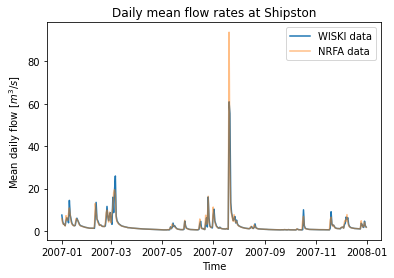

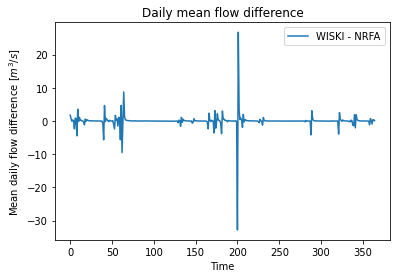

In [178]:
plt.plot(shipston_flow_wiski["2007"], label="WISKI data")
plt.plot(shipston_flow_nrfa["2007"], label="NRFA data", alpha=0.5)
plt.title("Daily mean flow rates at Shipston")
plt.ylabel("Mean daily flow [$m^3/s$]")
plt.xlabel("Time")
plt.legend()
plt.show()

plt.plot(
    shipston_flow_wiski["2007"].values.flatten() - shipston_flow_nrfa["2007"].values,
    label="WISKI - NRFA",
)
plt.title("Daily mean flow difference")
plt.ylabel("Mean daily flow difference [$m^3/s$]")
plt.xlabel("Time")
plt.legend()

We therefore see that the Wiski and NRFA data do not align perfectly, especially on days where there were floods. 
--> __We should ask the EA about this__.

## GP Regression to map stage to flow data a la Matt

Get rid of any input pairs to the regression with missing values

In [144]:
df_flow_and_stage_complete = df_flow_and_stage[
    df_flow_and_stage["Quality_flow"] != "missing"
]
df_flow_and_stage_complete = df_flow_and_stage_complete[
    df_flow_and_stage_complete["flow"].notnull()
]

Use a Gaussian process to predict flow data from stage data - taking every 500th data point to save memory, and also including the 100 data points with the highest value, because there aren't very many in that range and most of them would get missed by only taking 1/500th of the data.

In [147]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

X = df_flow_and_stage_complete["stage"].values.reshape(-1, 1)
y = df_flow_and_stage_complete["flow"].values

y = y[np.argsort(X, axis=0)]  # Reorder them from time order to ascending by value
X = np.sort(X, axis=0)  # So that the line plot looks sensible

X_train = np.append(
    X[0::500], X[-100:], axis=0
)  # Every 500th data point and the last 100
y_train = np.append(y[0::500], y[-100:], axis=0)


# Sort X_train into ascending order (for plotting)


kernel = RBF(1, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1 ** 2)

gp.fit(X_train, y_train)

print(gp.kernel_)

RBF(length_scale=0.712)


In [148]:
y_pred, sigma = gp.predict(X, return_std=True)

mean_sq_err = ((y_pred - y) ** 2).mean()

print("RMS error in flow is: " + str(np.sqrt(mean_sq_err)) + " [m³/s]")

mean_abs_prc_err = (abs((y_pred - y) / y)).mean()

print("MAP error in flow is: " + str(100 * mean_abs_prc_err) + "%")

RMS error in flow is: 0.17866404034708033 [m³/s]
MAP error in flow is: 6.083800715151814%


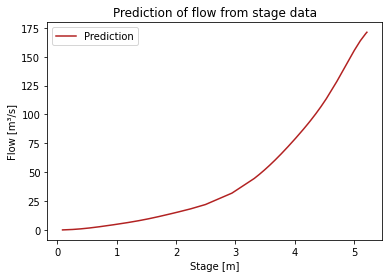

In [149]:
# Plot predictions based on the training data to avoid memory errors
y_pred_train, sigma = gp.predict(X_train, return_std=True)

plt.figure()
plt.plot(X_train, y_pred_train, "firebrick", label="Prediction")
# plt.scatter(X, y, marker='x', color='coral', label = 'Observations')
plt.xlabel("Stage [m]")
plt.ylabel("Flow [m³/s]")
plt.title("Prediction of flow from stage data")

plt.legend(loc="upper left")

plt.show()

<ipython-input-150-d36da259579d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage60_filtered_no_missing['predicted_flow'] = predicted_flow


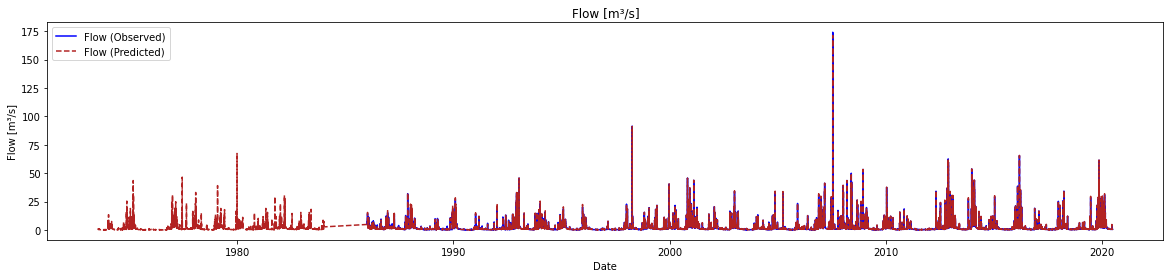

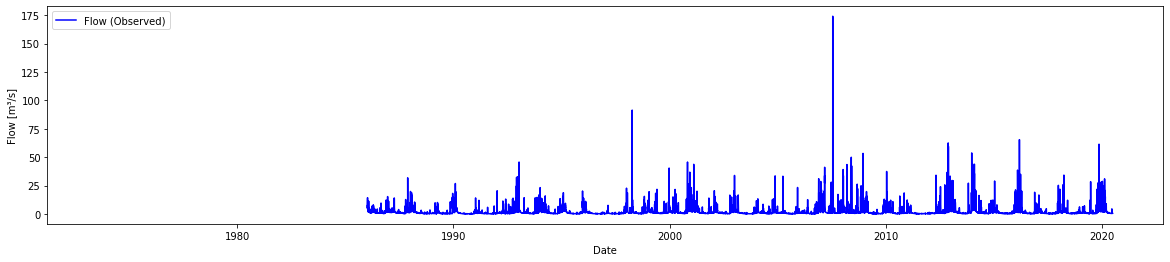

In [150]:
plt.figure(figsize=(20, 4))

plt.plot(
    flow60_filtered["Date_Time"],
    flow60_filtered["Flow [m³/s]"],
    "blue",
    label="Flow (Observed)",
)

stage60_filtered_no_missing = stage60_filtered[
    stage60_filtered["Quality"] != "missing"
]  # Remove rows with stage missing

# Predict the flow from the remaining stage values
predicted_flow = gp.predict(
    stage60_filtered_no_missing["Stage [m]"].values.reshape(-1, 1)
)

stage60_filtered_no_missing["predicted_flow"] = predicted_flow

plt.plot(
    stage60_filtered_no_missing["Date_Time"],
    predicted_flow,
    "firebrick",
    label="Flow (Predicted)",
    linestyle="--",
)

lims = plt.xlim()

plt.title("Flow [m³/s]")
plt.xlabel("Date")
plt.ylabel("Flow [m³/s]")

plt.legend(loc="upper left")


plt.figure(figsize=(20, 4))
plt.plot(
    flow60_filtered["Date_Time"],
    flow60_filtered["Flow [m³/s]"],
    "blue",
    label="Flow (Observed)",
)
plt.xlim(lims)

plt.xlabel("Date")
plt.ylabel("Flow [m³/s]")

plt.legend(loc="upper left")

# N.B I've not managed to get rid of the SettingWithCopyWarning which is probably fairly important but I can't be bothered
# and I don't do much more with it so it works anyway.

## Saving processed data in camels GB format

In [211]:
predicted_flow_hourly = pd.Series(
    data=predicted_flow.flatten(), index=stage60_filtered_no_missing["Date_Time"]
)

# Resample hourly predictions to daily predictions
predicted_flow_daily = predicted_flow_hourly.resample("d").mean().dropna(how="all")
predicted_flow_daily.name = "flow (from stage)"

In [212]:
# Combinde WISKI and NRFA data
processed_shipston_flow = pd.merge(
    pd.DataFrame(predicted_flow_daily), 
    shipston_flow_wiski, 
    on="Date_Time", 
    how="outer"
)
processed_shipston_flow = pd.merge(
    processed_shipston_flow,
    pd.DataFrame(shipston_flow_nrfa),
    on="Date_Time",
    how="outer",
)

# Renaming
processed_shipston_flow.rename(
    mapper={
        "flow (from stage)": "discharge_vol (wiski-predicted)",
        "flow": "discharge_vol (wiski-observed)",
        "Gauged Daily Flow [m3/s]": "discharge_vol (nrfa-observed)",
    },
    axis=1,
    inplace=True,
)

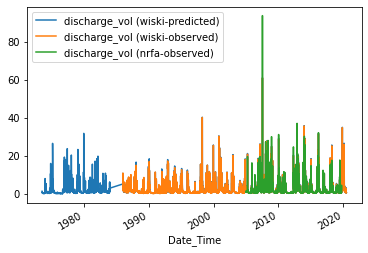

In [213]:
processed_shipston_flow.plot();

In [214]:
def discharge_vol_to_spec(discharge_vol, catchment_area):
    """
    Converts a series of discharge_vol [m3/s] values to discharge_spec [mm/d]
    via dividing through the catchment area and converting the units.
    
    Args:
        discharge_vol (array-like): The flow values in [m3/s] to transform
        catchment_area (float): The area of the catchment in km2.
    """
    
    # Conversion factor
    #  km2 --> m2 (1/1e6)
    #   m  --> mm (1e3)
    #   s  --> d  (24*3600)
    conversion_factor = 24*3.6
    
    return discharge_vol / catchment_area * conversion_factor

In [221]:
for col in processed_shipston_flow.columns:
    new_colname = f"discharge_spec {col.split(' ')[1]}"
    
    func = lambda x: discharge_vol_to_spec(x, shipston_catchment_area)
    processed_shipston_flow[new_colname] = processed_shipston_flow[col].apply(func)
    

In [224]:
# Save data
save_path = os.path.join(DATA_PATH, "shipston_hydro_timeseries.csv")
processed_shipston_flow.to_csv(save_path)